![](https://raw.githubusercontent.com/UGS-CS/CSC3009/master/mashead.svg)

# <center>**Group Project T11**</center>

## **Project Setup**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Import libraries and settings

In [4]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance


# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Data Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# For ML Models
from tensorflow.keras.applications import MobileNet, Xception, VGG16, EfficientNetB4, inception_v3, DenseNet201, ResNet50
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Miscellaneous
from tqdm import tqdm
import os
import random
import pickle
import shutil
import zipfile


Setting up project directories

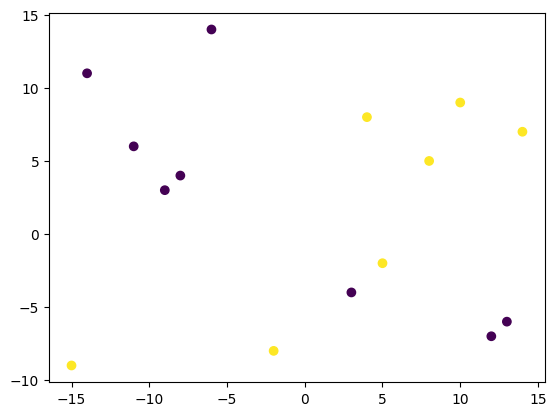

In [5]:
# unzip the file
zip_file_path = '/content/drive/MyDrive/brain_mri/dataset_11.zip'
dest_dir = '/content/drive/MyDrive/brain_mri'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dest_dir)

print(f'Unzipped files to {dest_dir}')

# set the paths of train and test directories
original_dataset_dir = '/content/drive/MyDrive/brain_mri/dataset_11'
base_dir = '/content/drive/MyDrive/brain_mri/'

# Define the train and test directories
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Testing')

# Create the train and test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Define the categories
categories = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Create subdirectories for each category in train and test directories
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Set the split ratio, 80% for training, 20% for testing
split_ratio = 0.8  

# Function to split data
def split_data(category, split_ratio):
    category_path = os.path.join(original_dataset_dir, category)
    images = os.listdir(category_path)
    random.shuffle(images)
    split_point = int(len(images) * split_ratio)
    
    train_images = images[:split_point]
    test_images = images[split_point:]
    
    for image in train_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(train_dir, category, image)
        shutil.copyfile(src, dst)
        
    for image in test_images:
        src = os.path.join(category_path, image)
        dst = os.path.join(test_dir, category, image)
        shutil.copyfile(src, dst)

# Split data for each category
for category in categories:
    split_data(category, split_ratio)

print("Data split into training and testing sets successfully.")

image_data_paths = r"/content/drive/MyDrive/brain_mri/"
train_dir = os.path.join(image_data_paths,"Training")
test_dir = os.path.join(image_data_paths,"Testing")

# print total number of data in train and test directories
train_data = shuffle(read_dataset(train_dir))
print(f'training image number: {len(train_data)}')

test_data = read_dataset(test_dir)
print(f'test image number: {len(test_data)}')

Reading the data

In [ ]:
def read_dataset(data_path):
    data = []

    for label in os.listdir(data_path):
        real_label = ""
        if label in ['pituitary_tumor', 'pituitary']:
            real_label = 'pituitary'
        elif label in ['no_tumor', 'notumor']:
            real_label = 'notumor'
        elif label in ['meningioma', 'meningioma_tumor']:
            real_label = 'meningioma'
        elif label in ['glioma', 'glioma_tumor']:
            real_label = 'glioma'
        for image in os.listdir(os.path.join(data_path,label)):
            data.append([os.path.join(data_path,label,image),real_label])

    return data

## **Data visualisation for each class**

In [6]:
def pie_chart(axis, data, title, colors, explode):
    axis.pie(data.values(), labels=data.keys(), autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
    axis.axis('equal')  
    axis.set_title(title, weight='bold')

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for train_data
label_counts_train = train_data['tumor_class'].value_counts().to_dict()
total_count_train = sum(label_counts_train.values())
label_percentages_train = {label: count / total_count_train * 100 for label, count in label_counts_train.items()}
colors_train = ['lightgray', 'dimgray', 'slategrey', 'seagreen']
explode_train = (0, 0, 0, 0.1)
pie_chart(axes[0], label_percentages_train, 'Training Data Distribution', colors_train, explode_train)

# Plot for test_data
label_counts_test = test_data['tumor_class'].value_counts().to_dict()
total_count_test = sum(label_counts_test.values())
label_percentages_test = {label: count / total_count_test * 100 for label, count in label_counts_test.items()}
colors_test = ['dimgray', 'seagreen', 'slategrey', 'lightgray']
explode_test = (0, 0.1, 0, 0)
pie_chart(axes[1], label_percentages_test, 'Testing Data Distribution', colors_test, explode_test)

plt.tight_layout()
plt.show()


## **Data agumentation & Normalisation**

1. create a smaller subset of the training data, splitting into training and validation sets

In [7]:
train_data, val_data = train_test_split(train_data,
                                               train_size = 0.70,
                                               random_state = 42,
                                               stratify = train_data.tumor_class)

print(train_data.shape),
print(val_data.shape),
print(test_data.shape)

2. Perform data agumentation to improve the CNN's resilency by expanding the image dataset via flipping, adjusting brightness and etc
3. Perform normalisation by rescalling training, training validation and test datasets to ensure the model is able to make predicitions on unseen data during the testing and validation steps.

In [8]:
image_size = 128
batch_size = 64

train_image_datagen_kwargs = dict(rescale = 1 / 255,
                                rotation_range = 15,
                                width_shift_range = 0.1,
                                zoom_range = 0.02,
                                shear_range = 0.01,
                                brightness_range = [0.3, 1.5],
                                horizontal_flip = True,
                                vertical_flip = True,
                                fill_mode = "nearest"
                                )

test_image_datagen_kwargs = dict(rescale = 1 / 255)

#With agumentation
train_image_datagen = ImageDataGenerator(**train_image_datagen_kwargs)
test_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs)
# Without agumentation
val_image_datagen = ImageDataGenerator(**test_image_datagen_kwargs)

train_dataset = train_image_datagen.flow_from_dataframe(train_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')

test_dataset = test_image_datagen.flow_from_dataframe(test_data,
                                                      x_col = 'image_filepaths',
                                                      y_col = 'tumor_class',
                                                      seed = 42,
                                                      shuffle=False,
                                                      batch_size = batch_size,
                                                      target_size = (image_size, image_size),
                                                      color_mode = 'rgb')

val_dataset = val_image_datagen.flow_from_dataframe(val_data,
                                                        x_col = 'image_filepaths',
                                                        y_col = 'tumor_class',
                                                        seed = 42,
                                                        shuffle=False,
                                                        batch_size = batch_size,
                                                        target_size = (image_size, image_size),
                                                        color_mode = 'rgb')

## **Developing the Model**

1. Introducing early stopping to stop the training when no improvement is observed

In [9]:
early_stopping = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 10)

2. Defining a custom base model

In [10]:
def model_def(base_model):

  # Set all layers to non-trainable
  for layer in base_model.layers:
      layer.trainable = False
  # Set the last block to trainable for fine-tuning
  base_model.layers[-2].trainable = True  
  base_model.layers[-3].trainable = True
  base_model.layers[-4].trainable = True

  # build a custom model
  model = Sequential()
  model.add(Input(shape=(image_size,image_size,3)))
  model.add(base_model) 
  model.add(Flatten())  #reshape the output to 1D vector
  model.add(Dropout(0.3)) # To reduce overfitting, we add a dropout layer with a rate of 0.3.
  model.add(Dense(128, activation='relu')) # Adds a fully connected layer with 128 units
  model.add(Dropout(0.2)) # Add another dropout layer with a rate of 0.2
  model.add(Dense(4, activation='sigmoid')) # Add a fully connected layer with 4 units and a sigmoid activation function

  return model

### MODEL 1: VGG16

In [11]:
model_vgg = model_def(VGG16(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_vgg.summary()

In [ ]:
keras.utils.plot_model(model_vgg, show_shapes=True)

In [ ]:
#use ADAM optimizer and learning rate of 0.0001
model_vgg.compile(optimizer=Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

# Set the checkpoint interval
checkpoint_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size)) 
# Set the checkpoint folder
checkpoint_folder = r"drive/MyDrive/brain_mri/Model-Checkpoints/vgg"
# Set the checkpoint path
checkpoint_path = os.path.join(checkpoint_folder,r"epocch_{epoch:02d}.hdf5")

model_vgg_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    verbose=1,
    save_freq= checkpoint_interval
)


In [ ]:
%%time
train_history_vgg = model_vgg.fit(train_dataset,
                          batch_size = batch_size,
                          validation_data = val_dataset,
                          epochs = 50,
                          callbacks = [early_stopping, model_vgg_checkpoint_callback])

# Save the train history
with open(os.path.join(checkpoint_folder,'train_history_vgg'), 'wb') as file_pi:
    pickle.dump(train_history_vgg, file_pi)

In [ ]:
# to load history from previous traines model
with open(os.path.join(checkpoint_folder,'train_history_vgg'), 'rb') as file_pi:
    train_history_vgg = pickle.load(file_pi)

In [ ]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# plot catergorical accuracy and validation accuracy
axes[0].grid(True)
axes[0].plot(train_history_vgg.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_vgg.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('VVG16 Model Training History Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_vgg.history['categorical_accuracy']),5))
axes[0].legend(['Train','Validation'], loc='upper left')

# plot Training loss and validation loss
axes[1].grid(True)
axes[1].plot(train_history_vgg.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_vgg.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)
axes[1].set_title('VVG16 Model Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_vgg.history['loss']),5))
axes[1].legend(['Train','Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
test_epoch = '15'
weights_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/vgg/epocch_"+test_epoch+".hdf5"
model_vgg.load_weights(weights_path)

# Evaluate VGG16 model on the test set
evaluation_results_vgg = model_vgg.evaluate(test_dataset)

# Print the evaluation results
print(f'VGG16 model Test Loss: {evaluation_results_vgg[0]}')
print(f'VGG16 model Test Accuracy: {evaluation_results_vgg[1]}')

In [ ]:
# predict the test data
y_pred = model_vgg.predict(test_dataset)

In [ ]:
#create confusion matrix for VVG16 model
categories_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

#confusion matrix
conf_matrix = confusion_matrix(test_dataset.labels, np.argmax(y_pred, axis=1))
conf_matrix_data = np.array(conf_matrix)

# plotting the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of VGG16 Model')
plt.show()



In [ ]:
# print classification report
print(classification_report(test_dataset.labels, np.argmax(y_pred, axis=1), target_names=categories_labels))

### MODEL 2: EfficientNetB4 

In [13]:
model_efficientnet = model_def(EfficientNetB4(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_efficientnet.summary()

Epoch 1/10, MSE: 0.5333333333333333
Epoch 2/10, MSE: 0.3333333333333333
Epoch 3/10, MSE: 0.7333333333333333
Epoch 4/10, MSE: 0.26666666666666666
Epoch 5/10, MSE: 0.26666666666666666
Epoch 6/10, MSE: 0.6
Epoch 7/10, MSE: 0.26666666666666666
Epoch 8/10, MSE: 0.26666666666666666
Epoch 9/10, MSE: 0.6666666666666666
Epoch 10/10, MSE: 0.3333333333333333


In [ ]:
keras.utils.plot_model(model_efficientnet, show_shapes=True)

In [ ]:
model_efficientnet.compile(optimizer=Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

In [ ]:
checkpoint_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size))
checkpoint_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/efficientnet"
checkpoint_path = os.path.join(checkpoint_folder,r"epocch_{epoch:02d}.hdf5")

model_efficientnet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    verbose=1,
    save_freq= checkpoint_interval
)

In [ ]:
%%time

train_history_efficientnet = model_efficientnet.fit(train_dataset,
                            batch_size = batch_size,
                            validation_data = val_dataset,
                            epochs = 50,
                            callbacks = [early_stopping, model_efficientnet_checkpoint_callback])
# save the train history
with open(os.path.join(checkpoint_folder,'train_history_efficientnet'), 'wb') as file_pi:
    pickle.dump(train_history_efficientnet, file_pi)

In [ ]:
print(train_history_efficientnet.history.keys())

In [ ]:
# load history from previous trained model
with open(os.path.join(checkpoint_folder,'train_history_efficientnet'), 'rb') as file_pi:
    train_history_efficientnet = pickle.load(file_pi)

In [ ]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# plot categorical accuracy and validation accuracy
axes[0].grid(True)
axes[0].plot(train_history_efficientnet.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_efficientnet.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('EfficientNetB4 Model Training History Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_efficientnet.history['categorical_accuracy']),5))
axes[0].legend(['Train','Validation'], loc='upper left')

# plot Training loss and validation loss
axes[1].grid(True)
axes[1].plot(train_history_efficientnet.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_efficientnet.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)
axes[1].set_title('EfficientNetB4 Model Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_efficientnet.history['loss']),5))
axes[1].legend(['Train','Validation'], loc='upper left')

plt.tight_layout()
plt.show()



In [ ]:
test_epoch = '15'
weights_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/efficientnet/epocch_"+test_epoch+".hdf5"
model_efficientnet.load_weights(weights_path)


In [ ]:
# Evaluate EfficientNetB4 model on the test set
evaluation_results_efficientnet = model_efficientnet.evaluate(test_dataset)

# Print the evaluation results
print(f'EfficientNetB4 model Test Loss: {evaluation_results_efficientnet[0]}')
print(f'EfficientNetB4 model Test Accuracy: {evaluation_results_efficientnet[1]}')

In [ ]:
# predict the test data
y_pred = model_efficientnet.predict(test_dataset)

In [ ]:
#create confusion matrix for EfficientNetB4 model
categories_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

#confusion matrix
conf_matrix = confusion_matrix(test_dataset.labels, np.argmax(y_pred, axis=1))
conf_matrix_data = np.array(conf_matrix)

# plotting the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of EfficientNetB4 Model')
plt.show()


In [ ]:
# print classification report
print(classification_report(test_dataset.labels, np.argmax(y_pred, axis=1), target_names=categories_labels))

## MODEL 3: Xception 

In [14]:
model_xception = model_def(Xception(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_xception.summary()

Epoch 1/10, MSE: 0.3153070672736686
Epoch 2/10, MSE: 0.24691124105155476
Epoch 3/10, MSE: 0.45849052309776034
Epoch 4/10, MSE: 0.2693353242689438
Epoch 5/10, MSE: 0.23586059689737487
Epoch 6/10, MSE: 0.331753607895466
Epoch 7/10, MSE: 0.26326105030807745
Epoch 8/10, MSE: 0.4093606175834446
Epoch 9/10, MSE: 0.27041578267390004
Epoch 10/10, MSE: 0.25791161934756557


In [15]:
keras.utils.plot_model(model_xception, show_shapes=True)

Epoch 1/10, MSE: 0.5159480863977284
Epoch 2/10, MSE: 0.47797669584461766
Epoch 3/10, MSE: 0.46835955877134494
Epoch 4/10, MSE: 0.4593317828875094
Epoch 5/10, MSE: 0.4506453467292958
Epoch 6/10, MSE: 0.442285331300939
Epoch 7/10, MSE: 0.4342392860427051
Epoch 8/10, MSE: 0.4264952595792989
Epoch 9/10, MSE: 0.41904176404968685
Epoch 10/10, MSE: 0.411867756560678


In [16]:
model_xception.compile(optimizer=Adam(learning_rate = 0.0001),
             loss='categorical_crossentropy',
             metrics=['categorical_accuracy'])

Epoch 1/5, MSE: 0.3153070672736686
Epoch 2/5, MSE: 0.24691124105155476
Epoch 3/5, MSE: 0.45849052309776034
Epoch 4/5, MSE: 0.2693353242689438
Epoch 5/5, MSE: 0.23586059689737487


In [17]:
checkpoint_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size))
checkpoint_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/xception"
checkpoint_path = os.path.join(checkpoint_folder,r"epocch_{epoch:02d}.hdf5")

model_xception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    verbose=1,
    save_freq= checkpoint_interval
)

Epoch 1/15, MSE: 0.3153070672736686
Epoch 2/15, MSE: 0.24691124105155476
Epoch 3/15, MSE: 0.45849052309776034
Epoch 4/15, MSE: 0.2693353242689438
Epoch 5/15, MSE: 0.23586059689737487
Epoch 6/15, MSE: 0.331753607895466
Epoch 7/15, MSE: 0.26326105030807745
Epoch 8/15, MSE: 0.4093606175834446
Epoch 9/15, MSE: 0.27041578267390004
Epoch 10/15, MSE: 0.25791161934756557
Epoch 11/15, MSE: 0.24095712313545897
Epoch 12/15, MSE: 0.41222611060374026
Epoch 13/15, MSE: 0.2710864000819326
Epoch 14/15, MSE: 0.23621489112103392
Epoch 15/15, MSE: 0.263614420353723


In [18]:
%%time
train_history_xception = model_xception.fit(train_dataset,
                            batch_size = batch_size,
                            validation_data = val_dataset,
                            epochs = 50,
                            callbacks = [early_stopping, model_xception_checkpoint_callback])
# save the train history
with open(os.path.join(checkpoint_folder,'train_history_xception'), 'wb') as file_pi:
    pickle.dump(train_history_xception, file_pi)

Epoch 1/5, MSE: 0.5159480863977284
Epoch 2/5, MSE: 0.47797669584461766
Epoch 3/5, MSE: 0.46835955877134494
Epoch 4/5, MSE: 0.4593317828875094
Epoch 5/5, MSE: 0.4506453467292958


In [19]:
# load history from previous trained model
with open(os.path.join(checkpoint_folder,'train_history_xception'), 'rb') as file_pi:
    train_history_xception = pickle.load(file_pi)


Epoch 1/15, MSE: 0.5159480863977284
Epoch 2/15, MSE: 0.47797669584461766
Epoch 3/15, MSE: 0.46835955877134494
Epoch 4/15, MSE: 0.4593317828875094
Epoch 5/15, MSE: 0.4506453467292958
Epoch 6/15, MSE: 0.442285331300939
Epoch 7/15, MSE: 0.4342392860427051
Epoch 8/15, MSE: 0.4264952595792989
Epoch 9/15, MSE: 0.41904176404968685
Epoch 10/15, MSE: 0.411867756560678
Epoch 11/15, MSE: 0.4049626215324115
Epoch 12/15, MSE: 0.3983161537668313
Epoch 13/15, MSE: 0.3919185422074028
Epoch 14/15, MSE: 0.3857603543608207
Epoch 15/15, MSE: 0.3798325213527549


In [20]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# plot categorical accuracy and validation accuracy
axes[0].grid(True)
axes[0].plot(train_history_xception.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_xception.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('Xception Model Training History Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_xception.history['categorical_accuracy']),5))
axes[0].legend(['Train','Validation'], loc='upper left')

# plot Training loss and validation loss
axes[1].grid(True)
axes[1].plot(train_history_xception.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_xception.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)
axes[1].set_title('Xception Model Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_xception.history['loss']),5))
axes[1].legend(['Train','Validation'], loc='upper left')

plt.tight_layout()
plt.show()

Epoch 1/5, MSE: 0.5333333333333333
Epoch 2/5, MSE: 0.3333333333333333
Epoch 3/5, MSE: 0.7333333333333333
Epoch 4/5, MSE: 0.26666666666666666
Epoch 5/5, MSE: 0.26666666666666666


In [21]:
test_epoch = '15'
weights_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/xception/epocch_"+test_epoch+".hdf5"
model_xception.load_weights(weights_path)

Epoch 1/15, MSE: 0.5333333333333333
Epoch 2/15, MSE: 0.3333333333333333
Epoch 3/15, MSE: 0.7333333333333333
Epoch 4/15, MSE: 0.26666666666666666
Epoch 5/15, MSE: 0.26666666666666666
Epoch 6/15, MSE: 0.6
Epoch 7/15, MSE: 0.26666666666666666
Epoch 8/15, MSE: 0.26666666666666666
Epoch 9/15, MSE: 0.6666666666666666
Epoch 10/15, MSE: 0.3333333333333333
Epoch 11/15, MSE: 0.26666666666666666
Epoch 12/15, MSE: 0.7333333333333333
Epoch 13/15, MSE: 0.3333333333333333
Epoch 14/15, MSE: 0.26666666666666666
Epoch 15/15, MSE: 0.6666666666666666


In [ ]:
# Evaluate Xception model on the test set
evaluation_results_xception = model_xception.evaluate(test_dataset)

# Print the evaluation results
print(f'Xception model Test Loss: {evaluation_results_xception[0]}')
print(f'Xception model Test Accuracy: {evaluation_results_xception[1]}')


In [ ]:
# predict the test data
y_pred = model_xception.predict(test_dataset)

In [ ]:
#create confusion matrix for Xception model
categories_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

#confusion matrix
conf_matrix = confusion_matrix(test_dataset.labels, np.argmax(y_pred, axis=1))
conf_matrix_data = np.array(conf_matrix)

# plotting the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of Xception Model')
plt.show()

In [ ]:
# print classification report
print(classification_report(test_dataset.labels, np.argmax(y_pred, axis=1), target_names=categories_labels))

## Model 4: MobileNet

In [ ]:
model_MobileNet = model_def(MobileNet(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_MobileNet.summary()


In [ ]:
keras.utils.plot_model(model_MobileNet, show_shapes=True)

In [ ]:
model_MobileNet.compile(optimizer=Adam(learning_rate = 0.0001),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

In [ ]:
checkpoint_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size))
checkpoint_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/MobileNet"
checkpoint_path = os.path.join(checkpoint_folder,r"epocch_{epoch:02d}.hdf5")

model_MobileNet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    verbose=1,
    save_freq= checkpoint_interval
)


In [ ]:
%%time
train_history_MobileNet = model_MobileNet.fit(train_dataset,
                            batch_size = batch_size,
                            validation_data = val_dataset,
                            epochs = 50,
                            callbacks = [early_stopping, model_MobileNet_checkpoint_callback])


# save the train history
with open(os.path.join(checkpoint_folder,'train_history_MobileNet'), 'wb') as file_pi:
    pickle.dump(train_history_MobileNet, file_pi)

In [ ]:
# load history from previous trained model
with open(os.path.join(checkpoint_folder,'train_history_MobileNet'), 'rb') as file_pi:
    train_history_MobileNet = pickle.load(file_pi)

In [ ]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# plot categorical accuracy and validation accuracy
axes[0].grid(True)
axes[0].plot(train_history_MobileNet.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_MobileNet.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('MobileNet Model Training History Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_MobileNet.history['categorical_accuracy']),5))
axes[0].legend(['Train','Validation'], loc='upper left')

# plot Training loss and validation loss
axes[1].grid(True)
axes[1].plot(train_history_MobileNet.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_MobileNet.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)
axes[1].set_title('MobileNet Model Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_MobileNet.history['loss']),5))
axes[1].legend(['Train','Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
test_epoch = '15'
weights_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/MobileNet/epocch_"+test_epoch+".hdf5"
model_MobileNet.load_weights(weights_path)


In [ ]:
# Evaluate MobileNet model on the test set
evaluation_results_MobileNet = model_MobileNet.evaluate(test_dataset)

# Print the evaluation results
print(f'MobileNet model Test Loss: {evaluation_results_MobileNet[0]}')
print(f'MobileNet model Test Accuracy: {evaluation_results_MobileNet[1]}')


In [ ]:
# predict the test data
y_pred = model_MobileNet.predict(test_dataset)

In [ ]:
#create confusion matrix for MobileNet model
categories_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

#confusion matrix
conf_matrix = confusion_matrix(test_dataset.labels, np.argmax(y_pred, axis=1))
conf_matrix_data = np.array(conf_matrix)

# plotting the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of MobileNet Model')
plt.show()

In [ ]:
# print classification report
print(classification_report(test_dataset.labels, np.argmax(y_pred, axis=1), target_names=categories_labels))


## Model 5: Inception


In [ ]:
model_inception = model_def(inception_v3.InceptionV3(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_inception.summary()

In [ ]:
keras.utils.plot_model(model_inception, show_shapes=True)

In [ ]:
model_inception.compile(optimizer=Adam(learning_rate = 0.0001),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])

In [ ]:
checkpoint_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size))
checkpoint_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/inception"
checkpoint_path = os.path.join(checkpoint_folder,r"epocch_{epoch:02d}.hdf5")

model_inception_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    verbose=1,
    save_freq= checkpoint_interval
)

In [ ]:
%%time
train_history_inception = model_inception.fit(train_dataset,
                            batch_size = batch_size,
                            validation_data = val_dataset,
                            epochs = 50,
                            callbacks = [early_stopping, model_inception_checkpoint_callback])

# save the train history
with open(os.path.join(checkpoint_folder,'train_history_inception'), 'wb') as file_pi:
    pickle.dump(train_history_inception, file_pi)

In [ ]:
# load history from previous trained model
with open(os.path.join(checkpoint_folder,'train_history_inception'), 'rb') as file_pi:
    train_history_inception = pickle.load(file_pi)
    

In [ ]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# plot categorical accuracy and validation accuracy
axes[0].grid(True)
axes[0].plot(train_history_inception.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_inception.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('InceptionV3 Model Training History Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_inception.history['categorical_accuracy']),5))
axes[0].legend(['Train','Validation'], loc='upper left')

# plot Training loss and validation loss
axes[1].grid(True)
axes[1].plot(train_history_inception.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_inception.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)
axes[1].set_title('InceptionV3 Model Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_inception.history['loss']),5))
axes[1].legend(['Train','Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
test_epoch = '15'
weights_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/inception/epocch_"+test_epoch+".hdf5"
model_inception.load_weights(weights_path)


In [ ]:
# evaluate InceptionV3 model on the test set
evaluation_results_inception = model_inception.evaluate(test_dataset)

# print the evaluation results
print(f'InceptionV3 model Test Loss: {evaluation_results_inception[0]}')
print(f'InceptionV3 model Test Accuracy: {evaluation_results_inception[1]}')


In [ ]:
# predict the test data
y_pred = model_inception.predict(test_dataset)


In [ ]:
#create confusion matrix for InceptionV3 model
categories_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

#confusion matrix
conf_matrix = confusion_matrix(test_dataset.labels, np.argmax(y_pred, axis=1))
conf_matrix_data = np.array(conf_matrix)

# plotting the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of InceptionV3 Model')
plt.show()

In [ ]:
# print classification report
print(classification_report(test_dataset.labels, np.argmax(y_pred, axis=1), target_names=categories_labels))

## Model 6: DenseNet201

In [ ]:
model_DenseNet = model_def(DenseNet201(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_DenseNet.summary()

In [ ]:
keras.utils.plot_model(model_DenseNet, show_shapes=True)

In [ ]:
model_DenseNet.compile(optimizer=Adam(learning_rate = 0.0001),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])


In [ ]:
checkpoint_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size))
checkpoint_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/DenseNet"
checkpoint_path = os.path.join(checkpoint_folder,r"epocch_{epoch:02d}.hdf5")

model_DenseNet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    verbose=1,
    save_freq= checkpoint_interval
)


In [ ]:
%%time
train_history_DenseNet = model_DenseNet.fit(train_dataset,
                            batch_size = batch_size,
                            validation_data = val_dataset,
                            epochs = 50,
                            callbacks = [early_stopping, model_DenseNet_checkpoint_callback])

# save the train history
with open(os.path.join(checkpoint_folder,'train_history_DenseNet'), 'wb') as file_pi:
    pickle.dump(train_history_DenseNet, file_pi)

In [ ]:
# load history from previous trained model
with open(os.path.join(checkpoint_folder,'train_history_DenseNet'), 'rb') as file_pi:
    train_history_DenseNet = pickle.load(file_pi)

In [ ]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# plot categorical accuracy and validation accuracy
axes[0].grid(True)
axes[0].plot(train_history_DenseNet.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_DenseNet.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('DenseNet201 Model Training History Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_DenseNet.history['categorical_accuracy']),5))
axes[0].legend(['Train','Validation'], loc='upper left')

# plot Training loss and validation loss
axes[1].grid(True)
axes[1].plot(train_history_DenseNet.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_DenseNet.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)
axes[1].set_title('DenseNet201 Model Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_DenseNet.history['loss']),5))
axes[1].legend(['Train','Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
test_epoch = '15'
weights_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/DenseNet/epocch_"+test_epoch+".hdf5"
model_DenseNet.load_weights(weights_path)


In [ ]:
# Evaluate DenseNet201 model on the test set
evaluation_results_DenseNet = model_DenseNet.evaluate(test_dataset)

# Print the evaluation results
print(f'DenseNet201 model Test Loss: {evaluation_results_DenseNet[0]}')
print(f'DenseNet201 model Test Accuracy: {evaluation_results_DenseNet[1]}')

In [ ]:
# predict the test data
y_pred = model_DenseNet.predict(test_dataset)


In [ ]:
#create confusion matrix for DenseNet201 model
categories_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

#confusion matrix
conf_matrix = confusion_matrix(test_dataset.labels, np.argmax(y_pred, axis=1))
conf_matrix_data = np.array(conf_matrix)

# plotting the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of DenseNet201 Model')
plt.show()

In [ ]:
# print classification report
print(classification_report(test_dataset.labels, np.argmax(y_pred, axis=1), target_names=categories_labels))

## Model 7: ResNet50

In [ ]:
model_ResNet = model_def(ResNet50(input_shape=(image_size,image_size,3), include_top=False, weights='imagenet'))
model_ResNet.summary()


In [ ]:
keras.utils.plot_model(model_ResNet, show_shapes=True)

In [ ]:
model_ResNet.compile(optimizer=Adam(learning_rate = 0.0001),
                loss='categorical_crossentropy',
                metrics=['categorical_accuracy'])


In [ ]:
checkpoint_interval = 5 * int(np.ceil(train_data.shape[0]/batch_size))
checkpoint_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/ResNet"
checkpoint_path = os.path.join(checkpoint_folder,r"epocch_{epoch:02d}.hdf5")

model_ResNet_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='categorical_accuracy',
    verbose=1,
    save_freq= checkpoint_interval
)


In [ ]:
%%time
train_history_ResNet = model_ResNet.fit(train_dataset,
                            batch_size = batch_size,
                            validation_data = val_dataset,
                            epochs = 50,
                            callbacks = [early_stopping, model_ResNet_checkpoint_callback])

# save the train history
with open(os.path.join(checkpoint_folder,'train_history_ResNet'), 'wb') as file_pi:
    pickle.dump(train_history_ResNet, file_pi)

In [ ]:
# load history from previous trained model
with open(os.path.join(checkpoint_folder,'train_history_ResNet'), 'rb') as file_pi:
    train_history_ResNet = pickle.load(file_pi)

In [ ]:
# create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# plot categorical accuracy and validation accuracy
axes[0].grid(True)
axes[0].plot(train_history_ResNet.history['categorical_accuracy'], '.b-', linewidth=2, label='Categorical Accuracy')
axes[0].plot(train_history_ResNet.history['val_categorical_accuracy'], '.r-', linewidth=2, label='Validation Accuracy')
axes[0].set_title('ResNet50 Model Training History Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(range(0,len(train_history_ResNet.history['categorical_accuracy']),5))
axes[0].legend(['Train','Validation'], loc='upper left')

# plot Training loss and validation loss
axes[1].grid(True)
axes[1].plot(train_history_ResNet.history['loss'], '.b-', label='Training Loss', linewidth=2)
axes[1].plot(train_history_ResNet.history['val_loss'], '.r-', label='Validation Loss', linewidth=2)
axes[1].set_title('ResNet50 Model Training and Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(range(0,len(train_history_ResNet.history['loss']),5))
axes[1].legend(['Train','Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
test_epoch = '15'
weights_path = r"drive/MyDrive/brain_mri/Model-Checkpoints/ResNet/epocch_"+test_epoch+".hdf5"
model_ResNet.load_weights(weights_path)


In [ ]:
# Evaluate ResNet50 model on the test set
evaluation_results_ResNet = model_ResNet.evaluate(test_dataset)

# Print the evaluation results
print(f'ResNet50 model Test Loss: {evaluation_results_ResNet[0]}')
print(f'ResNet50 model Test Accuracy: {evaluation_results_ResNet[1]}')

In [ ]:
# predict the test data
y_pred = model_ResNet.predict(test_dataset)

In [ ]:
#create confusion matrix for ResNet50 model
categories_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

#confusion matrix
conf_matrix = confusion_matrix(test_dataset.labels, np.argmax(y_pred, axis=1))
conf_matrix_data = np.array(conf_matrix)

# plotting the matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_data, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of ResNet50 Model')
plt.show()


In [ ]:
# print classification report
print(classification_report(test_dataset.labels, np.argmax(y_pred, axis=1), target_names=categories_labels))

## Comparison & Analysis of Models

In [ ]:
categories_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

#confusion matrix for VGG16 model
conf_matrix_vgg = confusion_matrix(test_dataset.labels, np.argmax(model_vgg.predict(test_dataset), axis=1))
conf_matrix_data_vgg = np.array(conf_matrix_vgg)

#confusion matrix for EfficientNetB4 model
conf_matrix_efficientnet = confusion_matrix(test_dataset.labels, np.argmax(model_efficientnet.predict(test_dataset), axis=1))
conf_matrix_data_efficientnet = np.array(conf_matrix_efficientnet)

#confusion matrix for Xception model
conf_matrix_xception = confusion_matrix(test_dataset.labels, np.argmax(model_xception.predict(test_dataset), axis=1))
conf_matrix_data_xception = np.array(conf_matrix_xception)

#confusion matrix for MobileNet model
conf_matrix_MobileNet = confusion_matrix(test_dataset.labels, np.argmax(model_MobileNet.predict(test_dataset), axis=1))
conf_matrix_data_MobileNet = np.array(conf_matrix_MobileNet)

#confusion matrix for InceptionV3 model
conf_matrix_inception = confusion_matrix(test_dataset.labels, np.argmax(model_inception.predict(test_dataset), axis=1))
conf_matrix_data_inception = np.array(conf_matrix_inception)

#confusion matrix for DenseNet201 model
conf_matrix_DenseNet = confusion_matrix(test_dataset.labels, np.argmax(model_DenseNet.predict(test_dataset), axis=1))
conf_matrix_data_DenseNet = np.array(conf_matrix_DenseNet)

#confusion matrix for ResNet50 model
conf_matrix_ResNet = confusion_matrix(test_dataset.labels, np.argmax(model_ResNet.predict(test_dataset), axis=1))
conf_matrix_data_ResNet = np.array(conf_matrix_ResNet)

# plotting the matrix
fig, axes = plt.subplots(4, 2, figsize=(18, 24), sharey=True)

# VGG16 model
sns.heatmap(conf_matrix_data_vgg, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels, ax=axes[0])
axes[0].set_title('Confusion Matrix of VGG16 Model')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('True labels')

# EfficientNetB4 model
sns.heatmap(conf_matrix_data_efficientnet, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels, ax=axes[1])
axes[1].set_title('Confusion Matrix of EfficientNetB4 Model')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('True labels')

# Xception model
sns.heatmap(conf_matrix_data_xception, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels, ax=axes[2])
axes[2].set_title('Confusion Matrix of Xception Model')
axes[2].set_xlabel('Predicted labels')
axes[2].set_ylabel('True labels')

# MobileNet model
sns.heatmap(conf_matrix_data_MobileNet, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels, ax=axes[3])
axes[3].set_title('Confusion Matrix of MobileNet Model')
axes[3].set_xlabel('Predicted labels')
axes[3].set_ylabel('True labels')

# InceptionV3 model
sns.heatmap(conf_matrix_data_inception, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels, ax=axes[4])
axes[4].set_title('Confusion Matrix of InceptionV3 Model')
axes[4].set_xlabel('Predicted labels')
axes[4].set_ylabel('True labels')

# DenseNet201 model
sns.heatmap(conf_matrix_data_DenseNet, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels, ax=axes[5])
axes[5].set_title('Confusion Matrix of DenseNet201 Model')
axes[5].set_xlabel('Predicted labels')
axes[5].set_ylabel('True labels')

# ResNet50 model
sns.heatmap(conf_matrix_data_ResNet, annot=True, cmap='Blues', fmt='g', xticklabels=categories_labels, yticklabels=categories_labels, ax=axes[6])
axes[6].set_title('Confusion Matrix of ResNet50 Model')
axes[6].set_xlabel('Predicted labels')
axes[6].set_ylabel('True labels')

plt.tight_layout()
plt.show()

